# Lab 12: Modeling and Regerssion

In [31]:
library(tidyverse)
library(stringr)
library(modelr)

options(repr.plot.width=6, repr.plot.height=4)

## Review/Explore

### Modeling - Setup

The lecture notes have done a thorough job of explaining the setup of a statistical model. But in general when we model data we are trying to predict some output `y`, based on the some inputs, `x`, with some estimated error, epsilon.

$$\underbrace{Y}_{\text{outcome}} = \underbrace{f}_{\text{model function}}(\underbrace{X}_{\text{explainer}}) + 
    \underbrace{\epsilon}_\text{noise}$$

Where f(x) could be any type of model we think fits well with the data (e.g. fitting a line to the data, fitting a parabola to the data, fitting a series of curved lines, etc.) and the 'noise' here refers to the fact that we know our model isn't going to perfectly fit the data.

### Categorical and continuous data
`modelr::sim3` has both continuous and categorical data:

In [32]:
head(sim3)

x1,x2,rep,y,sd
1,a,1,-0.5707363,2
1,a,2,1.1841503,2
1,a,3,2.2373204,2
1,b,1,7.4366963,2
1,b,2,8.5182934,2
1,b,3,7.7239098,2


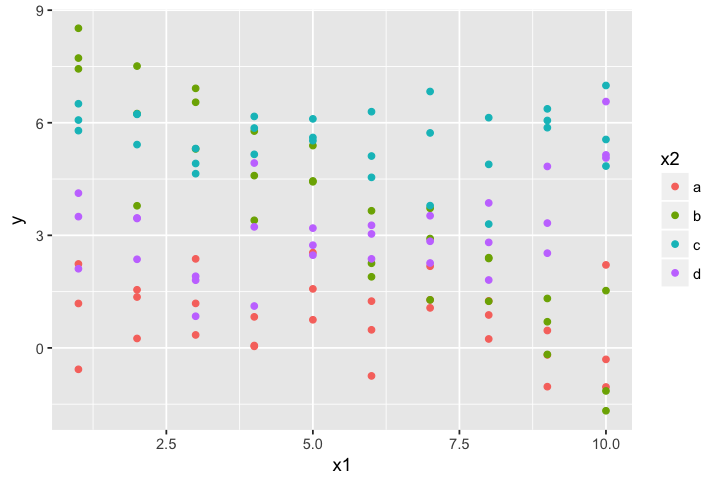

In [33]:
ggplot(sim3, aes(x1, y)) + 
  geom_point(aes(colour = x2))

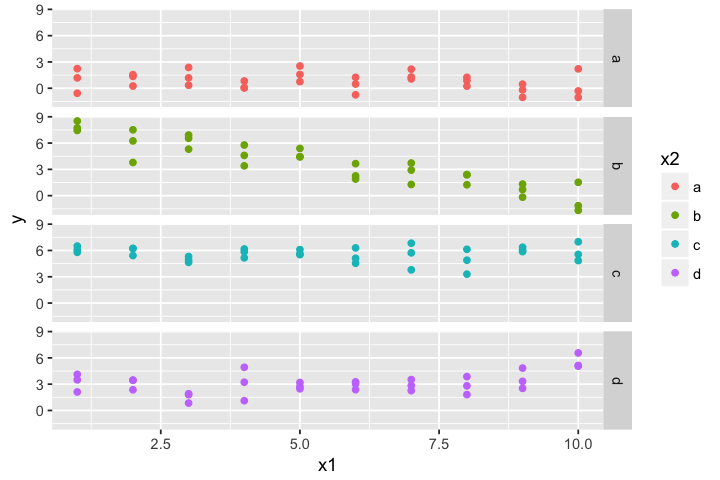

In [34]:
ggplot(sim3, aes(x1, y)) + 
    geom_point(aes(colour = x2)) + 
    facet_grid(x2 ~ .)

One way to model this data would be by adding both `x1` and `x2` to the model:

In [35]:
mod1 = lm(y ~ x1 + x2, data = sim3)
summary(mod1)


Call:
lm(formula = y ~ x1 + x2, data = sim3)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4674 -0.8524 -0.0729  0.7886  4.3005 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.87167    0.38738   4.832 4.22e-06 ***
x1          -0.19674    0.04871  -4.039 9.72e-05 ***
x2b          2.88781    0.39571   7.298 4.07e-11 ***
x2c          4.80574    0.39571  12.145  < 2e-16 ***
x2d          2.35959    0.39571   5.963 2.79e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.533 on 115 degrees of freedom
Multiple R-squared:  0.5911,	Adjusted R-squared:  0.5768 
F-statistic: 41.55 on 4 and 115 DF,  p-value: < 2.2e-16


Another option is to add an *interaction* between `x1` and `x2`:

In [36]:
mod2 = lm(y ~ x1 * x2, data = sim3)
summary(mod2)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.30124266,0.40399810,3.2209128,1.672947e-03
x1,-0.09302444,0.06511019,-1.4287233,1.558668e-01
x2b,7.06937991,0.57133959,12.3733416,1.091786e-22
x2c,4.43089525,0.57133959,7.7552743,4.406608e-12
x2d,0.83455115,0.57133959,1.4606920,1.468997e-01
x1:x2b,-0.76028528,0.09207971,-8.2568164,3.301095e-13
x1:x2c,0.06815284,0.09207971,0.7401505,4.607574e-01
x1:x2d,0.27727920,0.09207971,3.0112952,3.215600e-03


Now we get a number of new terms of the form `x1:x2<lvl>`. What do these represent?

Let's compare `mod1` and `mod2`. To do this we will use the `gather_predictions` function, which takes a data grid and one or more models and adds a new row for each prediction for each model:

In [37]:
grid = sim3 %>% data_grid(x1, x2) %>% 
    gather_predictions(mod1, mod2) %>% print

# A tibble: 80 x 4
   model    x1 x2     pred
   <chr> <int> <fct> <dbl>
 1 mod1      1 a      1.67
 2 mod1      1 b      4.56
 3 mod1      1 c      6.48
 4 mod1      1 d      4.03
 5 mod1      2 a      1.48
 6 mod1      2 b      4.37
 7 mod1      2 c      6.28
 8 mod1      2 d      3.84
 9 mod1      3 a      1.28
10 mod1      3 b      4.17
# ... with 70 more rows


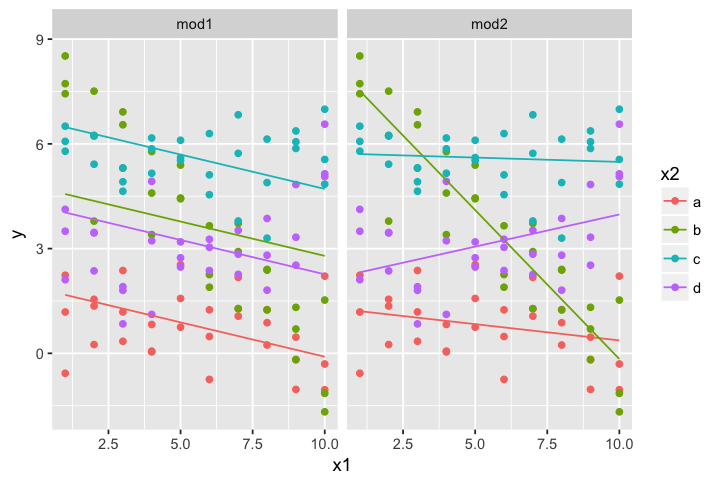

In [38]:
ggplot(sim3, aes(x1, y, color = x2)) + geom_point() + 
  geom_line(data = grid, aes(y = pred)) + 
  facet_grid( ~ model)

### Selecting between the models
How should we decide which model to use? We can make the same plots using `gather_residuals` instead of `gather_predicitons`:

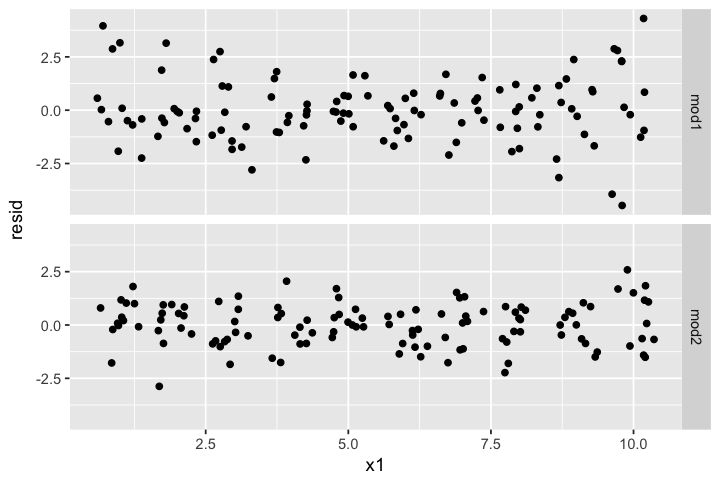

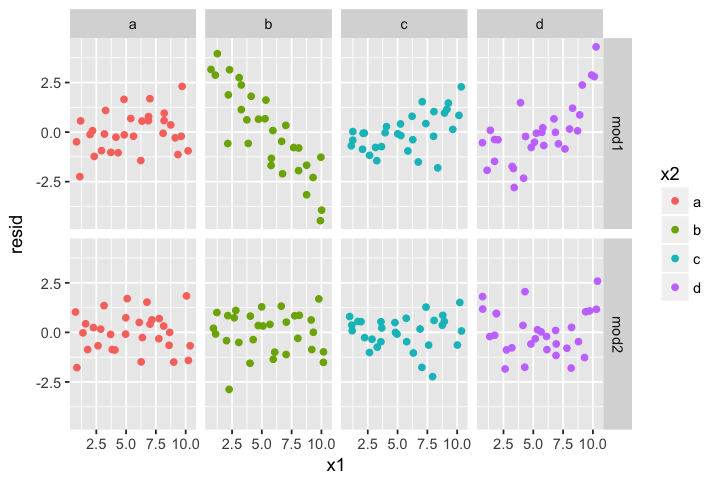

In [39]:
sim3_resid = sim3 %>% gather_residuals(mod1, mod2)

ggplot(sim3_resid, aes(x1, resid)) + 
  geom_point(position='jitter') +
  facet_grid(model ~ .)

ggplot(sim3_resid, aes(x1, resid, colour = x2)) + 
  geom_point(position='jitter') +
  facet_grid(model ~ x2)

Which model's residuals look better to you?

In [40]:
sim3_resid = sim3 %>% gather_residuals(mod1, mod2) %>% spread_predictions(mod1, mod2) %>%
    mutate(pred = ifelse(model=='mod1', mod1, mod2)) %>%
    select(-mod1, -mod2)

head(sim3_resid)

model,x1,x2,rep,y,sd,resid,pred
mod1,1,a,1,-0.5707363,2,-2.2456644,1.674928
mod1,1,a,2,1.1841503,2,-0.4907778,1.674928
mod1,1,a,3,2.2373204,2,0.5623923,1.674928
mod1,1,b,1,7.4366963,2,2.8739573,4.562739
mod1,1,b,2,8.5182934,2,3.9555544,4.562739
mod1,1,b,3,7.7239098,2,3.1611708,4.562739


In [41]:
sim3_resid %>% group_by(model) %>% summarize(corr=cor(resid, x1))
sim3_resid %>% group_by(model, x2) %>% summarize(corr=cor(resid, x1)) %>% mutate(corr=round(corr, 4))

model,corr
mod1,-4.260480e-16
mod2,-1.092895e-15


model,x2,corr
mod1,a,0.2988
mod1,b,-0.8758
mod1,c,0.5157
mod1,d,0.6981
mod2,a,0.0000
mod2,b,0.0000
mod2,c,0.0000
mod2,d,0.0000


## Power Law Distribution

In network theory, the degree of an node in a network is the number of connections or edges that node has to other nodes. As we studied in the facebook data last homework, we can define nodes as facebook users and degrees as number of friends in facebook network.

The degree distribution is the probability distribution of these degrees over the whole network. Let's revisit 'fb.Rdata' to explore the degree distribution.

In [80]:
load(url("https://raw.githubusercontent.com/rogerfan/stats306_f18_labs/master/fb.RData"))
fb_lst = unstack(fb, friend_id ~ user_id)
n_friends = map_int(fb_lst, length)

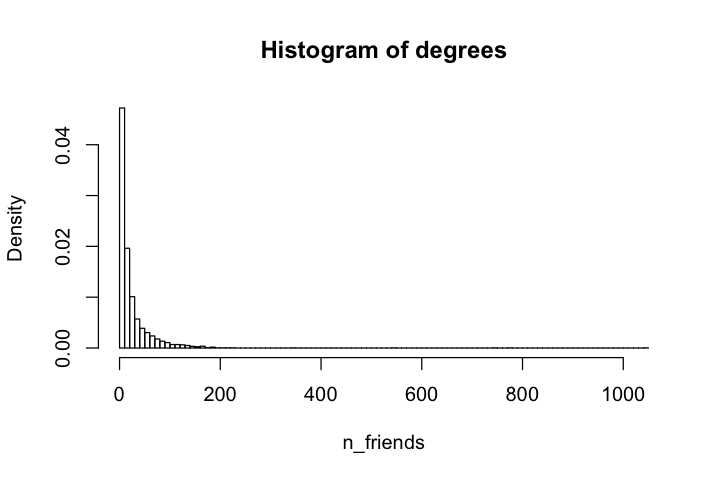

In [43]:
degree_dist = hist(n_friends, probability=TRUE, breaks=100, 
                   main='Histogram of degrees')

There are few examples in the real applications where we have a special property of the degree distribution. For example, if we look at the World Wide Web (WWW) network, the degree distribution follows a power law.

In statistics, a power law is a relationship between two quantities where one quantity is a power of another. We can write this relationship as

$$ p(x) = C x^\alpha$$

where $x$ is the number of degrees in our example. Then, we should see a straight line on a log-log plot as we have the following relationship

$$ \ln(p(x)) = \ln(C) + \alpha \ln(x)$$

Let's look at the facebook dataset and see if we can describe this relationship.

In [44]:
degree_data = data.frame(prob=degree_dist$density, 
                         degree=degree_dist$breaks[-1])
head(degree_data)

prob,degree
0.047229047,10
0.019628720,20
0.010101010,30
0.005705706,40
0.003876604,50
0.003030303,60


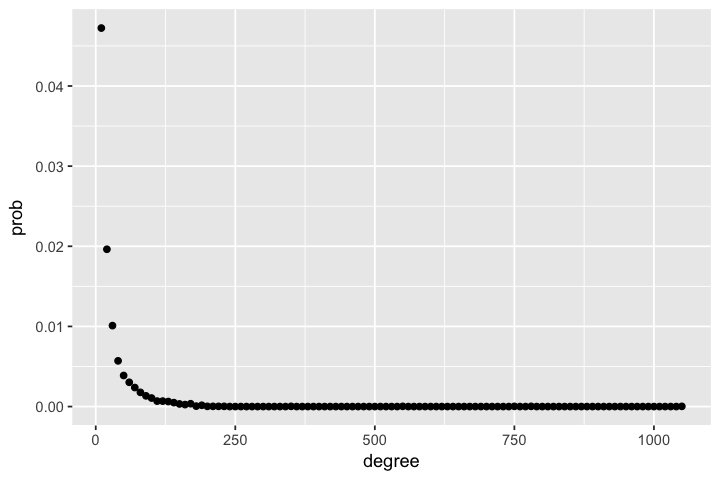

In [45]:
ggplot(data=degree_data, mapping=aes(x=degree, y=prob)) + geom_point()

As we mentioned before, we should see a linear relationship on a log-log scale.

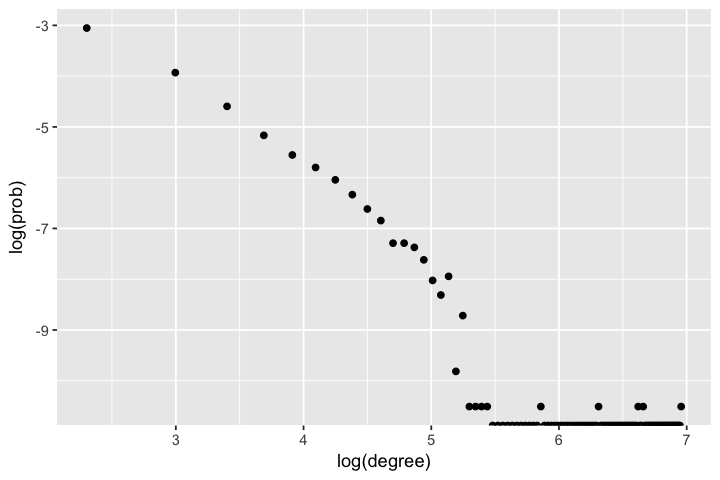

In [46]:
ggplot(data=degree_data, mapping=aes(x=log(degree), y=log(prob))) + geom_point()

In [77]:
degree_data_clean = degree_data %>% filter(prob != 0)
mod1 = lm(log(prob) ~ log(degree), data = degree_data_clean)
summary(mod1)


Call:
lm(formula = log(prob) ~ log(degree), data = degree_data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.61824 -0.31114  0.05012  0.27686  0.96962 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.61895    0.26226   -2.36   0.0212 *  
log(degree) -1.63766    0.06303  -25.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.513 on 66 degrees of freedom
Multiple R-squared:  0.9109,	Adjusted R-squared:  0.9096 
F-statistic: 675.1 on 1 and 66 DF,  p-value: < 2.2e-16


In [62]:
grid = degree_data %>% data_grid(degree) %>% gather_predictions(mod1)
head(grid)

model,degree,pred
mod1,2,-1.754093
mod1,4,-2.889234
mod1,6,-3.553249
mod1,8,-4.024376
mod1,10,-4.389809
mod1,12,-4.688391


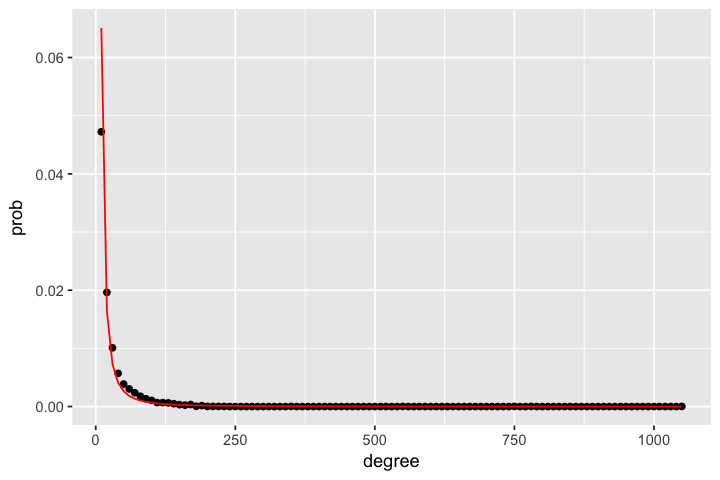

In [49]:
ggplot(degree_data, aes(x=degree, y=prob)) + geom_point() + 
  geom_line(data=grid, aes(y=exp(pred)), color='red')

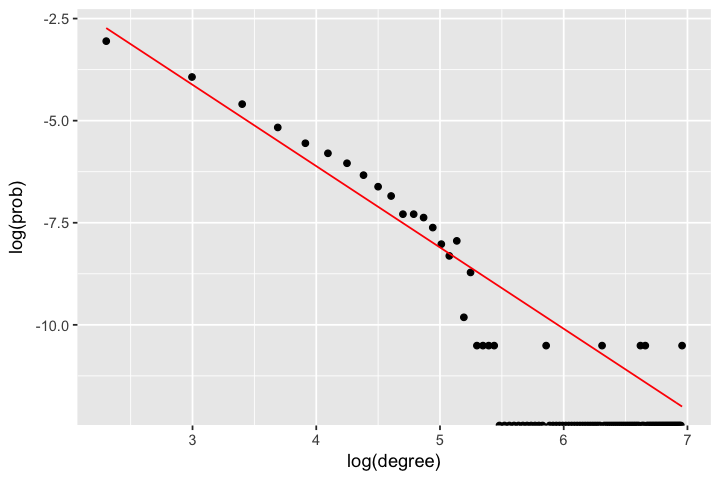

In [50]:
ggplot(degree_data, aes(x=log(degree), y=log(prob))) + geom_point() + 
  geom_line(data=grid, aes(y=pred), color='red')

In [78]:
summary(mod1)


Call:
lm(formula = log(prob) ~ log(degree), data = degree_data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.61824 -0.31114  0.05012  0.27686  0.96962 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.61895    0.26226   -2.36   0.0212 *  
log(degree) -1.63766    0.06303  -25.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.513 on 66 degrees of freedom
Multiple R-squared:  0.9109,	Adjusted R-squared:  0.9096 
F-statistic: 675.1 on 1 and 66 DF,  p-value: < 2.2e-16


## Flights Dataset
We are going to look into the power distribution of the network of airports. First let's look at how the distribution of degrees corresponds to certain networks.

![Slides from [1]](lab12_degree_dist.PNG)

We are going to repeat the above dataset analysis with the networks of airports.

In [81]:
airport_network = read.table('https://raw.githubusercontent.com/rogerfan/stats306_f18_labs/master/global-net.dat')
head(airport_network)
glimpse(airport_network)

V1,V2
1,1198
1,2482
1198,1
1198,1054
1198,2482
1198,1970


Observations: 28,284
Variables: 2
$ V1 <int> 1, 1, 1198, 1198, 1198, 1198, 2482, 2482, 2482, 2482, 2482, 2482...
$ V2 <int> 1198, 2482, 1, 1054, 2482, 1970, 1, 67, 92, 195, 370, 917, 1191,...


### Question 1.

Create a data frame `n_airports` with column names `c('airport', 'degree')`. The `airport` column should represent the available airports in the dataset and `degree` should be the number of airports that connect to that airport.

In [1]:
n_airports = NA

### Question 2.

Using the same procedure as above, create a model `mod1` that is calculated from regressing `log(degree)` on `log(prob)`. Just like in the above example, plot `log(prob)` against `log(degree)` and include a fit line for the predictions.

There are some problems with directly applying the linear regression on the log-log transform data. Look at the following slides from [2]

![Slides from [1]](lab12_powerLaw1.png)

![Slides from [1]](lab12_powerLaw2.png)

![Slides from [1]](lab12_powerLaw3.png)

### Question 3.

Using the logarithmic binning, create `mod2` which is the model fit on the log-log data using this new binning method. Hint: You can provide a vector to the `breaks` argument of the `hist` function to supply your own bins.

Create the same plot as in Question 2, but include the predictions from both `mod1` and `mod2`.

In [3]:
breaks = c(0, 2*1.5^(1:20))

[1] Barabasi, A-L. Network Science, the Scale-Free Property. [Link](http://barabasi.com/f/623.pdf)

[2] Eaton, Eric. Power-laws, scale free networks. [Link](https://cs.brynmawr.edu/Courses/cs380/spring2013/section02/slides/10_ScaleFreeNetworks.pdf)
